In [1]:
import random
import gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dropout
import time
import os
import gc
import psutil

In [2]:
#!pip install ale-py
#!pip install gym[atari,accept-rom-license]==0.21.0

In [3]:
path="./log_model.txt"
EPOCHS = 80 #number of epochs to train for
THRESHOLD = 25 #A threshold where if the Q value exceeds this, we consider the game to be solved
#MONITOR = True #A variable that is used by wrappers in gym

In [4]:
#Create the DQN class - in this we will code all the necessary attributes and methods to play the game of 
#Breakout for Atari, using DQN

class DQN():
    def __init__(self, env_string,batch_size=64, IM_SIZE = 84, m = 4):
        
        #Initialise memory as a double-ended queue to store experiences (state, action, reward, next_state, done)
        self.memory = deque(maxlen=5000) 
        
        #Attribute to store the environment made by gym - in this case for Breakout-v4
        self.env = gym.make(env_string)

        
        #Do we need this?
        #input_size = self.env.observation_space.shape[0]
        
        #The number of actions that can be taken - in the case of breakout v4 according to documentation
        #the action space is reduced to 4 - NOOP, FIRE, LEFT, RIGHT i.e. action_size = 4
        action_size = self.env.action_space.n
        
        #An attribute for the number of experiences we pass in a batch for training
        self.batch_size = batch_size
        
        self.gamma = 0.9 #Discount factor in update rule
        #self.epsilon = 1.0 #Parameter used for epsilon-greedy action selection
        self.epsilon = 1.0 #Parameter used for epsilon-greedy action selection
        self.epsilon_min = 0.01 #Used when decaying the value of epsilon i.e. less exploration as we learn
        self.epsilon_decay = 0.99925 #Used to control decay of epsilon, less exploration as we learn more
        self.IM_SIZE = IM_SIZE #Square images - dimension size of image fed to CNN part of the network
        self.m = m #Number of images fed together to the network to determine motion - set to 4 consectuive frames
       
        
        alpha=0.001 #learning rate used to control graident descent update step size
        alpha_decay=0.01 #decay factor for learning rate
        
        #We want ot use the Monitor class for the environment to data about observations in a wrapper
        #above the base environment
        #if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
        
        # Init model - the initial few layers are for the CNN portion of the network, for
        #processing the m=4 images we feed it - 
        self.model = Sequential()
        self.model.add( Conv2D(32, 8, (4,4), activation='elu',padding='valid', input_shape=(IM_SIZE, IM_SIZE, m),kernel_regularizer='l2'))
        self.model.add( Conv2D(64, 4, (2,2), activation='elu',padding='valid',kernel_regularizer='l2'))
        self.model.add( Conv2D(64, 3, (1,1), activation='elu',padding='valid',kernel_regularizer='l2'))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='elu'))
        self.model.add(Dropout(0.8))
        self.model.add(Dense(action_size, activation='linear')) #final layer connects to action_size number of actions
        
        #Loss function - as in slide 8 of week 9 notes - loss is based on squared difference
        #between target and actual Q values baed on weights, for a given state and action
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))
        
        #create a clone of the model
        self.model_target = tf.keras.models.clone_model(self.model)
        
    def remember(self, state, action, reward, next_state, done):
        #function for appening state, action, reward, next_state, done (as a tuple encompassing that experience) 
        #to memory (which as above is a double-ended queue of experiences)
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        #This is essentially epsilon-greedy action selection
        
        #randomly choose a number in range 0-1, so with probability epsilon i.e. if it the
        #random number is less than epsilon - sample a random action from the action_space
        #This is how we incorporate exploration
        if np.random.random() <= epsilon:
            return self.env.action_space.sample() #randomly chosen action
        else:
            #With probability 1-epsilon, we stick to the action that maximises Q value - model returns prediction of actions
            return np.argmax(self.model.predict(state,verbose=0))
        
    def preprocess_state(self, img):
        # Choose the important area of the image - ignore score at top
        #values for cropping here were chosen based on outputs of cell above
        img_temp = img[31:195] 
        #This is a preprocessing function for cropping and resizing images and convert them to grayscale
        img_temp = tf.image.rgb_to_grayscale(img_temp) #convert to grayscale 
        #resize the image to be square (IM_SIZE X IM_SIZE pixels), using tensorflow's nearest neighbour resize method
        #for interpolation
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        #convert image to float32
        img_temp = tf.cast(img_temp, tf.float32)
        return img_temp[:,:,0]
    
    def combine_images(self, img1, img2):
        #function for combining images together
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:, :],np.expand_dims(img2,0), axis=2)
            return tf.expand_dims(im, 0)
        else:
            im = np.stack([img1]*self.m, axis = 2)
            return tf.expand_dims(im, 0)
        
    def replay(self, batch_size):
        x_batch, y_batch = [], []
        #Chunk memory into minibatches of experience to train on - create targets and Q values of the current state (i.e. x)
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state,verbose=0)
            #print("y_target for model_target predict",y_target)
            #this is the target for DQN
            #the reward if reaching the terminal state
            #otherwise the discounted Q value for the next state
            #print("y_target[0][action] before ",y_target[0][action])
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model_target.predict(next_state,verbose=0)[0])
            #print("y_target[0][action] after ",y_target[0][action])
            #print("y_target for model predict",self.model.predict(next_state,verbose=0))
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        #fit the model based on targets and values
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        
    def train(self):
        #scores are a double-ended queue of length 100
        scores = deque(maxlen=100)
        #array for avergae scores - want to show average score per episode is increasing over epochs
        avg_scores = []
        steps_per_episode_list=[]
        episilon_list=[]
        score_for_episode_list=[]
        
        print('Epsilon: '+str(self.epsilon))
        for e in range(EPOCHS):
            print("\n Episode number : "+str(e))
            print("-----------------------------------------------------------------------------")
            state = self.env.reset()
            #preprocess the state to get cropped, grayscale images
            state = self.preprocess_state(state)
            #combine the image
            state = self.combine_images(state, state)
            done = False #initially we do not start at the terminal state
            i = 0 #counter for recording score
            start = time.time()
            steps_per_episode=0
            while not done:
                action = self.choose_action(state,self.epsilon) #choose an action based on epsilon-greedy policy
                next_state, reward, done, _ = self.env.step(action) #consider next state, reward, done, based on that action
                next_state = self.preprocess_state(next_state) 
                next_state = self.combine_images(next_state, state)
                self.remember(state, action, reward, next_state, done) #append experience to memory
                state = next_state #transition to next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward
                steps_per_episode+=1

            scores.append(i) #update score 
            score_for_episode = i
            score_for_episode_list.append(score_for_episode)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score) #update average score
            steps_per_episode_list.append(steps_per_episode)
            episilon_list.append(self.epsilon)
            
            if mean_score >= THRESHOLD:
                print('Solved after {} trials ✔'.format(e))
                return avg_scores
            
            if e%10==0:
                self.model_target.set_weights(self.model.get_weights())
            
            if e>25:
                self.replay(self.batch_size)
            
            end = time.time()
            with open(path,'w') as f:
                f.write(str({"avg_scores":avg_scores,"steps_per_episode_list":steps_per_episode_list,"episilon_list":episilon_list}))
                
            print('[Episode '+str(e)+'] - Average Score: '+str(mean_score))
            print('[Episode '+str(e)+'] - Individual Score: '+str(score_for_episode))
            print('[Episode '+str(e)+'] - Epsilon: '+str(self.epsilon))
            print('[Episode '+str(e)+'] - Total Steps: '+str(steps_per_episode))
            print('RAM memory % used:', psutil.virtual_memory()[2])
            print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)
            gc.collect()
            print("Time Taken : ",str(end-start))
        
        return avg_scores,steps_per_episode_list,episilon_list,score_for_episode_list

In [5]:
env_string = 'BreakoutDeterministic-v4'
agent = DQN(env_string)

C:\Users\yashs\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


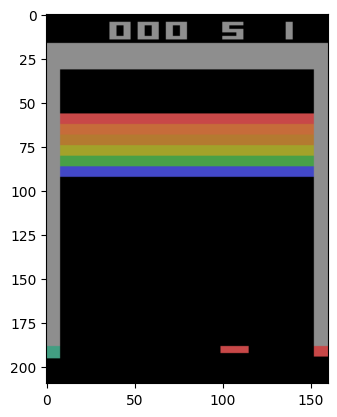

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(agent.env.render(mode='rgb_array'))

In [7]:
print(agent.env.action_space.n)
print(agent.env.get_action_meanings())

4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [8]:
print(agent.env.observation_space.shape)

(210, 160, 3)


In [9]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 256)               803072    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1

In [ ]:
scores,steps_per_episode_list,episilon_list,score_for_episode_list = agent.train()

Epsilon: 1.0

 Episode number : 0
-----------------------------------------------------------------------------
[Episode 0] - Average Score: 3.0
[Episode 0] - Individual Score: 3.0
[Episode 0] - Epsilon: 0.8195625305354088
[Episode 0] - Total Steps: 234
RAM memory % used: 55.7
RAM Used (GB): 9.397014528
Time Taken :  6.140679121017456

 Episode number : 1
-----------------------------------------------------------------------------
[Episode 1] - Average Score: 3.0
[Episode 1] - Individual Score: 3.0
[Episode 1] - Epsilon: 0.6676964058271891
[Episode 1] - Total Steps: 241
RAM memory % used: 55.3
RAM Used (GB): 9.33009408
Time Taken :  4.459308385848999

 Episode number : 2
-----------------------------------------------------------------------------
[Episode 2] - Average Score: 2.3333333333333335
[Episode 2] - Individual Score: 1.0
[Episode 2] - Epsilon: 0.5705020249855304
[Episode 2] - Total Steps: 185
RAM memory % used: 55.2
RAM Used (GB): 9.3072384
Time Taken :  3.812236785888672

 E

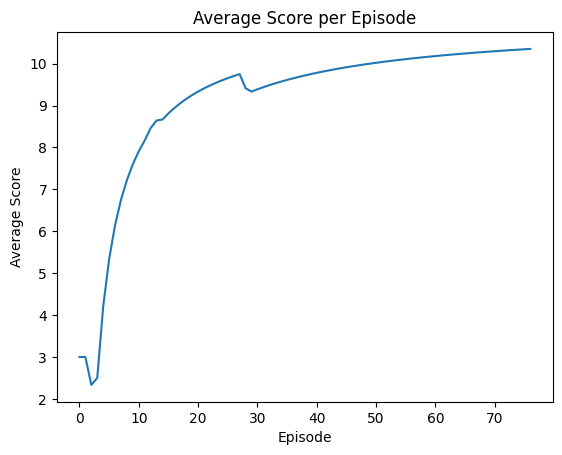

In [6]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Average Score per Episode")
plt.xlabel('Episode')
plt.ylabel('Average Score') 
plt.show()

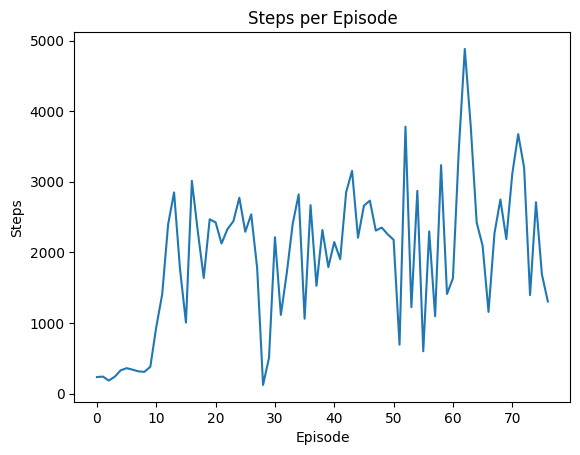

In [8]:
plt.plot(steps_per_episode_list)
plt.title("Steps per Episode")
plt.xlabel('Episode')
plt.ylabel('Steps') 
plt.show()

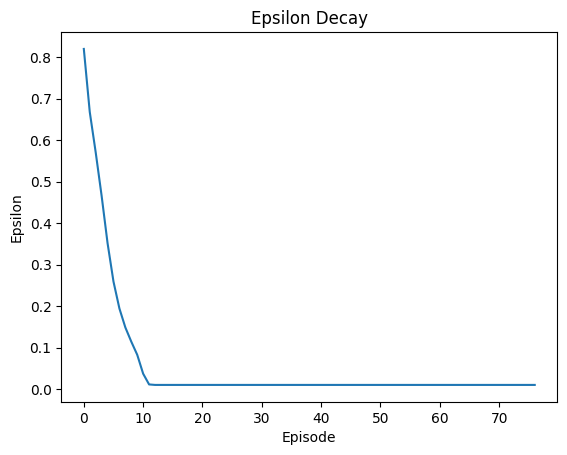

In [9]:
plt.plot(episilon_list)
plt.title("Epsilon Decay")
plt.xlabel('Episode')
plt.ylabel('Epsilon') 
plt.show()